In [72]:
import os
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import ts2xy
from stable_baselines3.common.evaluation import evaluate_policy

import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

from IPython.display import display, Markdown

import scipy.stats as st

import matplotlib.pyplot as plt

In [73]:
total_timesteps = 10000

In [74]:
def agent_eval(agent, n_eval_episodes=25, seed=42, verbose=1):
    eval_env = make_vec_env("LunarLander-v2", n_envs=16, seed=seed)
    reward_length = evaluate_policy(agent, eval_env, 
                           return_episode_rewards=True,
                           n_eval_episodes=n_eval_episodes,
                           deterministic=True)
    for i, p in enumerate(["mean", "length"]):
        mean = np.mean(reward_length[i])
        if verbose:
            sem = st.sem(reward_length[i])
            mean_CI = st.t.interval(0.95, df=len(reward_length[i])-1, loc=mean, scale=sem) 
        
            print(f"mean_{p}={mean:.3f}, SEM={sem}, CI=[{mean_CI[0]:.3f}:{mean_CI[1]:.3f}]")

    return np.mean(reward_length[0])

In [75]:
def _save_frames_as_gif(frames, path="./", filename="gym_animation.gif", fps=60):
    imageio.mimwrite(os.path.join(path, filename), frames, fps=fps)

def _add_text_info(frame, episode_num, step, reward):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), 
                f"Episode: {episode_num+1}\nStep: {step}\nCurrent reward: {reward}", 
                fill=text_color)
    return im

def save_trained_agent_gif(agent, path="./", filename="trained_agent.gif", n=1, fps=60):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    
    frames = []
    for i in range(n):
        R = 0
        observation, _ = env.reset()        
        for t in range(500):
            action, _ = agent.predict(observation, None, None, True)
            observation, reward, terminated, _, _ = env.step(action)
            R += reward
            frame = env.render()
            frames.append(_add_text_info(frame, episode_num=i, step=t, reward=R))
            if terminated:
                frames.extend([_add_text_info(frame, episode_num=i, step=t, reward=R)]*25)
                break
    
    env.close()

    _save_frames_as_gif(frames, path=path, filename=filename, fps=fps)

In [76]:
class RandomAgent(object):
    def __init__(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self._rng = np.random.default_rng(None)

    def predict(self, observations, state, episode_start, deterministic):
        rng = self.rng if deterministic else self._rng
        if len(observations.shape) == 1:
            return rng.integers(4, size=1)[0], None
        else: 
            return rng.integers(4, size=observations.shape[0]), None

In [77]:
agent_eval(RandomAgent(42))

mean_mean=-166.696, SEM=20.531574404168843, CI=[-209.071:-124.321]
mean_length=89.880, SEM=4.706491970317879, CI=[80.166:99.594]


-166.69573424

In [78]:
save_trained_agent_gif(RandomAgent(42), filename="random_agent.gif", n=2, fps=60)
#display(Markdown(f"<img src='random_agent.gif'>"))

In [114]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    fig = plt.figure(title, figsize=(10, 5))
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    min_x, max_x = min(x), max(x)
    plt.scatter(x, y, s=1)
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    plt.plot(x, y, color="black")
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " (Smoothed)")
    plt.xlim(min_x, max_x)
    plt.show()

In [80]:
# Define the callback function
class CustomCallback(BaseCallback):
    def __init__(self, log_dir: str, verbose=1):
        super(CustomCallback, self).__init__(verbose)
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf
        self.done_eps = 0

    def _check(self):
        results = load_results(self.log_dir)
        new_eps = len(results) - self.done_eps
        self.done_eps = len(results)
        x, y = ts2xy(results, 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-new_eps:])
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                if self.verbose > 0:
                    print(f"New best mean reward: {mean_reward:.2f}, eval_episodes: {new_eps}, total_steps: {self.num_timesteps}, total_episodes: {self.done_eps}")
                    self.model.save(self.save_path)

    def _init_callback(self) -> None:
        if self.log_dir is not None:
            os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        # if self.n_calls % self.check_freq == 0:
        #   self._check()
        return True

    def _on_training_end(self) -> None:
        interim_mean = agent_eval(self.model.load(self.save_path), verbose=0)
        final_mean = agent_eval(self.model, verbose=0)

        if interim_mean > final_mean:
            print(f"Interim model was better.")
            self.model.set_parameters(self.save_path)

        self.model.save(self.log_dir)

    def _on_rollout_end(self) -> None:
        self._check()

## PPO-Baseline

In [81]:
model_dir = "./models/PPO_baseline"

#env = gym.make("LunarLander-v2", continuous=False)

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="./tb_logs/")

# Load the model
# loaded_model = PPO.load("lunar_lander_model")

# Create the callback object
callback_object = CustomCallback(log_dir=model_dir)

# Train the model
model.learn(total_timesteps=total_timesteps, callback=callback_object, tb_log_name="v01_10k")

vec_env = model.get_env()

# Initialize total rewards
total_rewards = 0

New best mean reward: -183.74, eval_episodes: 340, total_steps: 32768, total_episodes: 340
Interim model was better.


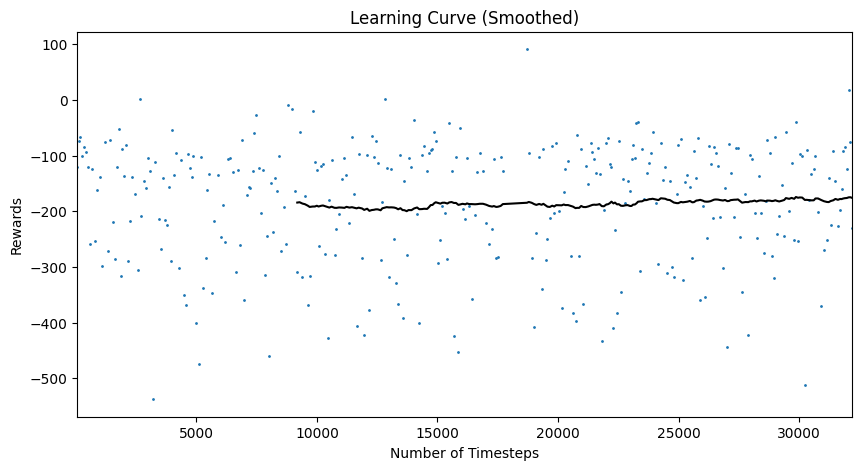

In [82]:
plot_results(model_dir)

In [83]:
agent_eval(model)

mean_mean=-676.335, SEM=138.62234180054602, CI=[-962.437:-390.233]
mean_length=113.720, SEM=14.759688343593165, CI=[83.258:144.182]


-676.33499116

In [84]:
save_trained_agent_gif(model, filename="ppo_baseline.gif", n=2, fps=60)
#display(Markdown(f"<img src='ppo_baseline.gif'>"))

## PPO-Tuned

In [85]:
model_dir = "./models/PPO_tuned"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir)
model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=512,
    batch_size=64,
    n_epochs=5,
    gamma=0.999,
    gae_lambda=0.98,
    ent_coef=0.01,
    verbose=0, 
    tensorboard_log="./tb_logs/"
)
callback = CustomCallback(log_dir=model_dir)

model.learn(total_timesteps=total_timesteps, callback=callback, tb_log_name="v02_10k")

New best mean reward: -187.50, eval_episodes: 81, total_steps: 8192, total_episodes: 81
New best mean reward: -150.24, eval_episodes: 91, total_steps: 16384, total_episodes: 172


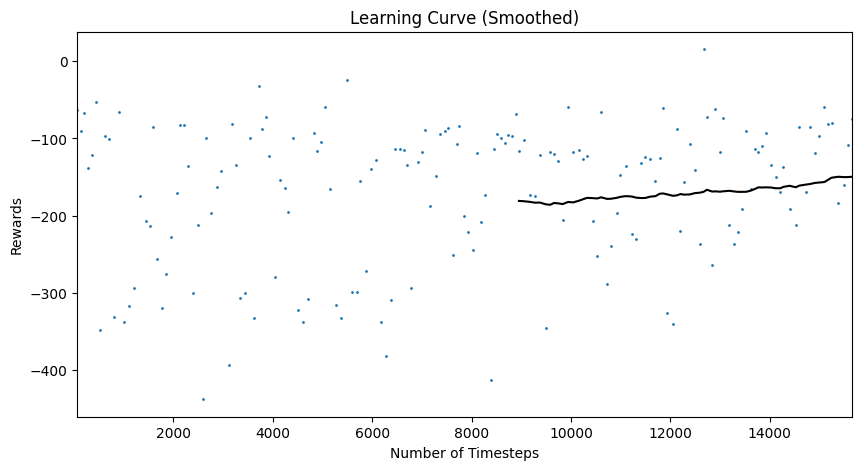

In [86]:
plot_results(model_dir)

In [87]:
agent_eval(model)

mean_mean=-54.949, SEM=15.880770044533326, CI=[-87.726:-22.173]
mean_length=494.600, SEM=91.51757572546742, CI=[305.717:683.483]


-54.94931864

In [88]:
save_trained_agent_gif(model, filename="ppo_v2.gif", n=2, fps=60)
#display(Markdown(f"<img src='ppo_v2.gif'>"))

## DQN-Baseline

In [89]:
model_dir = "./models/DQN_baseline"

#env = gym.make("LunarLander-v2", continuous=False)

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir)

# Create the DQN model
model = DQN("MlpPolicy", env, verbose=0, tensorboard_log="./tb_logs/")

# Load the model
# loaded_model = DQN.load("lunar_lander_model")

# Create the callback object
callback_object = CustomCallback(log_dir=model_dir)

# Train the model
model.learn(total_timesteps=total_timesteps, callback=callback_object, tb_log_name="v03_10k")

vec_env = model.get_env()

# Initialize total rewards
total_rewards = 0

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: -124.44, eval_episodes: 2, total_steps: 960, total_episodes: 2
New best mean reward: -7.37, eval_episodes: 1, total_steps: 1280, total_episodes: 4


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: 24.37, eval_episodes: 1, total_steps: 7936, total_episodes: 83
Interim model was better.


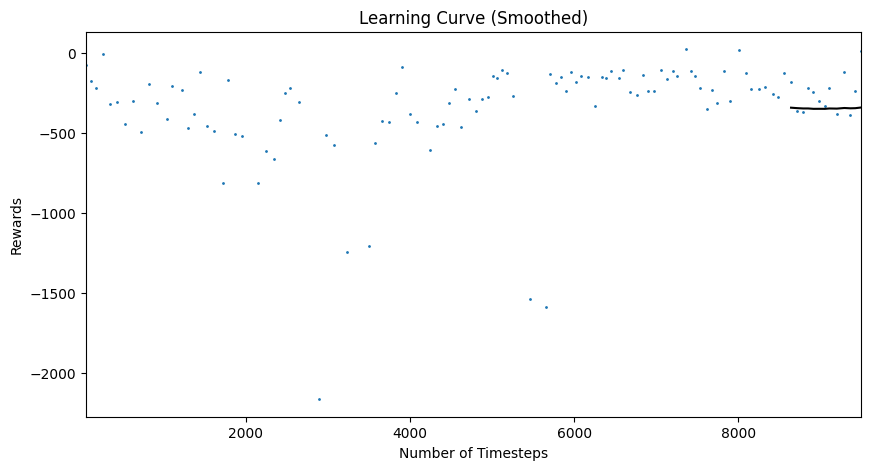

In [90]:
plot_results(model_dir)

In [91]:
agent_eval(model)

mean_mean=-215.439, SEM=19.404343321788083, CI=[-255.488:-175.391]
mean_length=69.040, SEM=2.5926048676958082, CI=[63.689:74.391]


-215.43916839999997

In [92]:
save_trained_agent_gif(model, filename="dqn_baseline.gif", n=2, fps=60)
#display(Markdown(f"<img src='dqn_baseline.gif'>"))

## DQN-Tuned

In [102]:
model_dir = "./models/DQN_tuned"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir)

# Create the DQN model
model = DQN(
    env=env,
    batch_size=128,
    #buffer_size=50000,
    exploration_final_eps=0.1,
    exploration_fraction=0.12,
    #gamma=0.99,
    #gradient_steps=-1,
    learning_rate=0.00063,
    #learning_starts=0,
    policy="MlpPolicy",
    #policy_kwargs=dict(net_arch=[256, 256]),
    #target_update_interval=250,
    #train_freq=4,
    verbose=0,
    tensorboard_log="./tb_logs/"
)

# Load the model
# loaded_model = DQN.load("lunar_lander_model")

# Create the callback object
callback_object = CustomCallback(log_dir=model_dir)

# Train the model
model.learn(total_timesteps=total_timesteps, callback=callback_object, tb_log_name="v04_10k")

vec_env = model.get_env()

# Initialize total rewards
total_rewards = 0

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


New best mean reward: -128.96, eval_episodes: 1, total_steps: 1280, total_episodes: 1


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: -113.24, eval_episodes: 1, total_steps: 1792, total_episodes: 2


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


New best mean reward: -100.73, eval_episodes: 1, total_steps: 1856, total_episodes: 3


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: -61.24, eval_episodes: 1, total_steps: 2176, total_episodes: 4


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: 6.58, eval_episodes: 1, total_steps: 4992, total_episodes: 6


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: 15.27, eval_episodes: 1, total_steps: 5760, total_episodes: 7


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

New best mean reward: 171.90, eval_episodes: 1, total_steps: 6144, total_episodes: 8


C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)
C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame =

C:\Users\h_enr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\stable_baselines3\common\monitor.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


ValueError: x and y must have same first dimension, but have shapes (9,) and (92,)

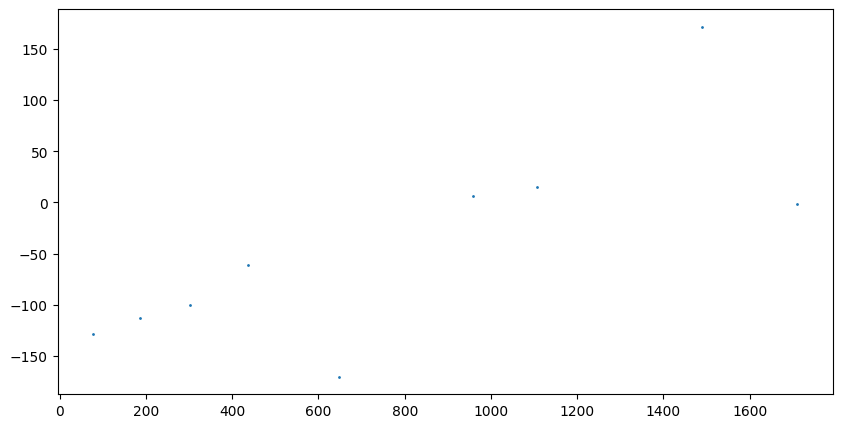

In [115]:
plot_results(model_dir)

In [ ]:
agent_eval(model)

In [ ]:
save_trained_agent_gif(model, filename="dqn_v02.gif", n=2, fps=60)
#display(Markdown(f"<img src='dqn_v02.gif'>"))